
## TURKISH
## Proje: Türkçe Metin Sınıflandırma
Bu projede, çeşitli Türkçe metinleri kategorilerine ayıran bir sınıflandırıcı geliştireceğiz. Kullanılacak model `TF-IDF` + `K-Means` olacak.

Veri kaynağı: Datas/data.csv
Hedef: 'content' sütunundaki metni kullanarak 'category' sütununu tahmin etmek.


In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from collections import Counter
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import string
import re

In [3]:
df = pd.read_csv('Datas/data.csv')
df.head()
df.sample(n=5)

,category,title,content
1102,Spor,2018'de yağlı güreş,2018 yılında toplamda 126 yağlı güreş düzenlen...
536,Ekonomi,a,bcypiiij lezzet durağıBeypiliç Başlıyor. Yumur...
401,Ekonomi,a,Mısır Yaz Sezonungjj Sübvansiyonu KalJEffij Ar...
1196,Spor,2021-22 Türkiye Erkekler Hentbol Süper Ligi,2021-22 Türkiye Erkekler Hentbol Süper Ligi Tü...
620,Kültürel,Boğaziçi Amatör Tiyatrolar Şenliği,Boğaziçi Amatör Tiyatrolar Şenliği Sarıyer Hal...


## İlk Gözlem
- `content`: metin verisi
- `category`: hedef sınıf (etiket)


In [4]:
# Boş değerleri sil.
# Küçük harfe çevir.
# Noktalama ve sayıları temizle.
# Stopwords temizliği yap.
# Stemming bu projede opsiyonel

nltk.download('stopwords')
stop_words = set(stopwords.words('turkish'))

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df.dropna(subset=['content', 'category'], inplace=True)
df['processed_data'] = df['content'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\uslan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<Axes: xlabel='category'>

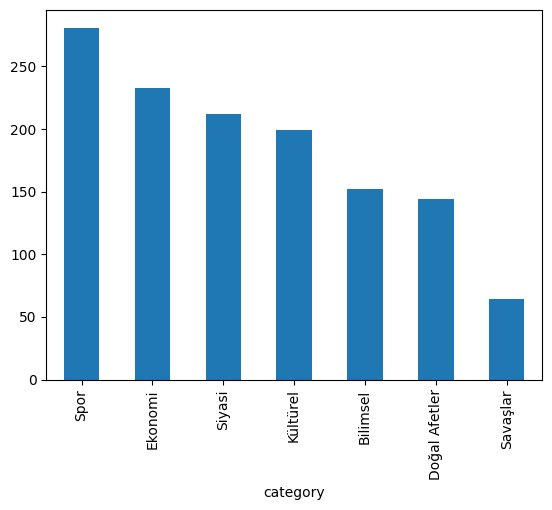

In [5]:
# Kategori dağılımını grafikle veya tabloda gör
df['category'].value_counts().plot(kind='bar')

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)  

X = vectorizer.fit_transform(df['processed_data'])


In [10]:
from sklearn.cluster import AgglomerativeClustering

# Küme sayısı belirleyelim (örnek: 5)
# normalde 7 kategori var
num_clusters = 7

kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X)

df['cluster'] = clusters

df[['category', 'cluster']].head()
df.sample(n=5)


,category,title,content,processed_data,cluster
380,Ekonomi,a,Türkiye nin üç büyük avantajı IADALYONUN İKİ Y...,türkiye nin üç büyük avantajı iadalyonun i̇ki̇...,1
533,Ekonomi,a,"Ege Seramik, 46 milyon TL lik çevreci tesis ya...",ege seramik milyon tl lik çevreci tesis yatırı...,1
447,Ekonomi,a,Afrika sıcakları buz talebini arttırdı Kuzey ...,afrika sıcakları buz talebini arttırdı kuzey a...,1
1116,Spor,2018-19 Kadınlar Ligi (buz hokeyi),"2018-19 Kadınlar Ligi, Kadınlar Ligi'nin 13. s...",kadınlar ligi kadınlar liginin sezonudur beş t...,5
548,Ekonomi,Savaş yılları,TürkiyeII. Dünya Savaşı'na girmemiş olsa da sa...,türkiyeii dünya savaşına girmemiş olsa savaşın...,1


In [11]:
le = LabelEncoder()
labels_num = le.fit_transform(df['category'])

cluster_label_map = {}
for cluster_id in np.unique(clusters):
    mask = (clusters == cluster_id)
    cluster_labels = labels_num[mask]
    if len(cluster_labels) == 0:
        continue
    most_common_num = Counter(cluster_labels).most_common(1)[0][0]
    cluster_label_map[cluster_id] = most_common_num

cluster_label_map_str = {cluster_id: le.inverse_transform([num])[0]
                         for cluster_id, num in cluster_label_map.items()}

predicted_num_categories = np.array([cluster_label_map[c] for c in clusters])
predicted_categories = le.inverse_transform(predicted_num_categories)

true_categories = df['category'].values
accuracy = accuracy_score(true_categories, predicted_categories)

print(f"K-Means doğruluk: {accuracy:.4f}")
for cid, cat in cluster_label_map_str.items():
    print(f"Cluster {cid} -> {cat}")

K-Means doğruluk: 0.5759
Cluster 0 -> Siyasi
Cluster 1 -> Ekonomi
Cluster 2 -> Spor
Cluster 3 -> Doğal Afetler
Cluster 4 -> Savaşlar
Cluster 5 -> Spor
Cluster 6 -> Spor


In [17]:
import numpy
print(numpy.__version__)

1.26.4


In [ ]:
import joblib

# Model ve vectorizer'ı kaydet
joblib.dump(kmeans, 'Models/k-mean_model.joblib')
joblib.dump(vectorizer, 'Models/tfidf_vectorizer.joblib')

# Daha sonra tekrar yüklemek için
agglo_loaded = joblib.load('Models/k-mean_model.joblib')
vectorizer_loaded = joblib.load('Models/tfidf_vectorizer.joblib')


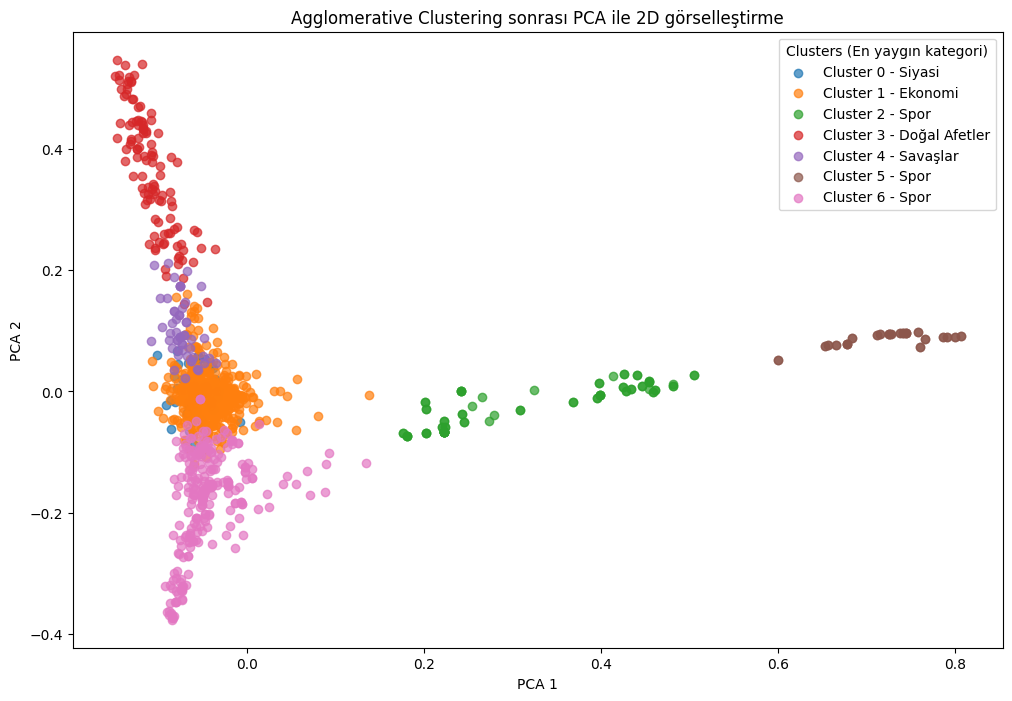

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# PCA ile 2 boyuta indir
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

num_clusters = len(np.unique(clusters))
colors = plt.cm.tab10.colors

plt.figure(figsize=(12,8))

for cluster_id in range(num_clusters):
    idx = np.where(clusters == cluster_id)
    plt.scatter(X_pca[idx,0], X_pca[idx,1], 
                color=colors[cluster_id % 10], 
                label=f"Cluster {cluster_id} - {cluster_label_map_str[cluster_id]}", 
                alpha=0.7)


plt.title('K-Means sonrası PCA ile 2D görselleştirme')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title="Clusters (En yaygın kategori)", loc='upper right')
plt.show()


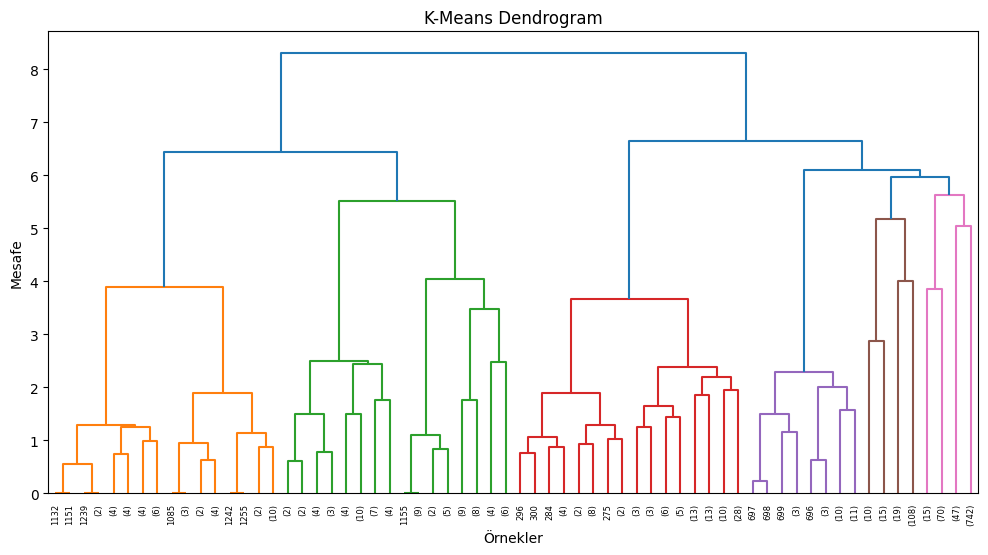

In [16]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

linked = linkage(X.toarray(), method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linked, truncate_mode='level', p=5)  # sadece ilk 5 seviyeyi gösterir
plt.title('K-Means Dendrogram')
plt.xlabel('Örnekler')
plt.ylabel('Mesafe')
plt.show()


## Grafik: Gerçek ve Tahmin Edilen Oranlar

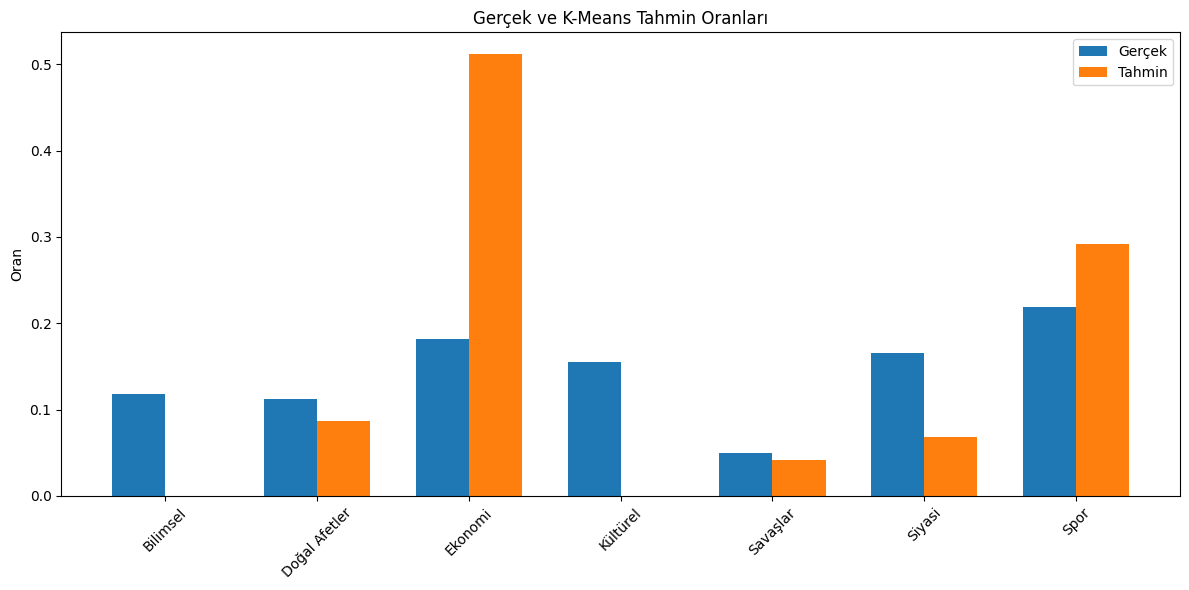

In [15]:
true_counts = df['category'].value_counts(normalize=True).sort_index()
predicted_counts = pd.Series(predicted_categories).value_counts(normalize=True).sort_index()

all_categories = sorted(set(true_counts.index).union(predicted_counts.index))
true_vals = [true_counts.get(cat, 0) for cat in all_categories]
predicted_vals = [predicted_counts.get(cat, 0) for cat in all_categories]

x = np.arange(len(all_categories))
width = 0.35

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(x - width/2, true_vals, width, label='Gerçek')
ax.bar(x + width/2, predicted_vals, width, label='Tahmin')
ax.set_ylabel('Oran')
ax.set_title('Gerçek ve K-Means Tahmin Oranları')
ax.set_xticks(x)
ax.set_xticklabels(all_categories, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()